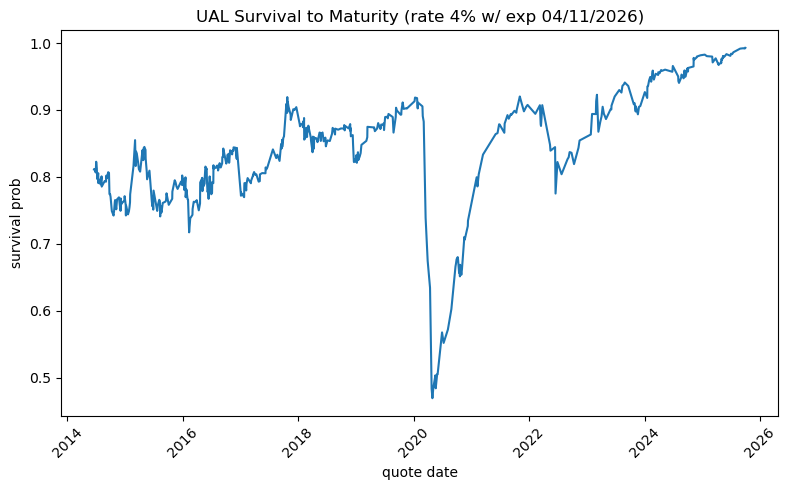

          date  last_value  spread_bps  spread_dec    hazard    tau_yrs  \
0   2014-06-19    106.3390    106.3390    0.010634  0.017723  11.819178   
1   2014-06-20    105.9590    105.9590    0.010596  0.017660  11.816438   
2   2014-06-23    106.1030    106.1030    0.010610  0.017684  11.808219   
3   2014-06-30    109.4790    109.4790    0.010948  0.018247  11.789041   
4   2014-07-03     99.5072     99.5072    0.009951  0.016585  11.780822   
5   2014-07-07    105.5130    105.5130    0.010551  0.017586  11.769863   
6   2014-07-08    110.0380    110.0380    0.011004  0.018340  11.767123   
7   2014-07-10    115.9600    115.9600    0.011596  0.019327  11.761644   
8   2014-07-16    110.5610    110.5610    0.011056  0.018427  11.745205   
9   2014-07-17    120.1020    120.1020    0.012010  0.020017  11.742466   
10  2014-07-18    116.3200    116.3200    0.011632  0.019387  11.739726   
11  2014-07-28    118.8150    118.8150    0.011881  0.019803  11.712329   

       s_tau  
0   0.811

In [235]:
#import libraries 

import pandas as pd, numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

#========================================

#loading csv 

file = r"/Users/liamrodgers/Desktop/Python/FE800/FE800-Research/data/raw/NewUAL/UALPricingnew.csv"
df = pd.read_csv(file)



#keeping date to last in spread 

df = df.rename(columns={"Date":"date","Last":"last_value"}).loc[:,["date","last_value"]]

#========================================

#parse dates + numeric 

def dates(x):
    
    for fmt in ("%m/%d/%Y","%m/%d/%y","%Y-%m-%d"):
        
        try: return datetime.strptime(str(x), fmt).date()
        except: pass
    return pd.NaT


def tnum(x):
    
    s = str(x).replace(",", "").strip()
    
    try: return float(s)
    except: return np.nan

##Function
def calculate_survival_probabilities(df, maturity_date, recovery_rate=0.4):
    """
    Calculate survival probabilities from CDS spread data using reduced-form model.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with 'date' and 'last_value' columns
    maturity_date : datetime.date
        Expected maturity date of the bond
    recovery_rate : float, optional
        Assumed recovery rate (default: 0.4)
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with survival probabilities and related metrics
    """
    # Parse dates and numeric values
    df["date"] = df["date"].apply(dates)
    df["last_value"] = df["last_value"].apply(tnum)
    df = df.dropna(subset=["date", "last_value"]).sort_values("date").reset_index(drop=True)
    
    # Calculate spread in basis points and decimal
    df["spread_bps"] = df["last_value"]          
    df["spread_dec"] = df["spread_bps"] / 1e4
    
    # Calculate hazard rate assuming recovery rate
    df["hazard"] = df["spread_dec"] / (1 - recovery_rate)
    
    # Calculate time to maturity
    df["tau_yrs"] = (pd.to_datetime(maturity_date) - pd.to_datetime(df["date"])).dt.days / 365.0
    df = df[df["tau_yrs"] >= 0].copy()
    
    # Calculate survival probability under constant hazard to maturity
    df["s_tau"] = np.exp(-df["hazard"] * df["tau_yrs"])
    
    return df
    

# Apply the function
expm = datetime(2026, 4, 11).date()
df = calculate_survival_probabilities(df, expm, recovery_rate=0.4)

#save as csv 

#saved = "/Users/anthonygiller/Downloads/UAL_reduced_form_survival.csv"
#df.to_csv("UAL_survival_to_maturity.csv", index=False)

#========================================

#plot survival prob 

plt.figure(figsize=(8,5))

plt.plot(df["date"], df["s_tau"])
plt.title("UAL Survival to Maturity (rate 4% w/ exp 04/11/2026)")
plt.xlabel("quote date") 
plt.ylabel("survival prob")

plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()


print(df.head(12))
print(df.columns)

In [236]:
df.rename(columns ={'tau_yrs': 'Time_to_Maturity'}, inplace=True)
df = df[['date', 'Time_to_Maturity', 'last_value', 'spread_bps', 'spread_dec', 'hazard', 's_tau']]

In [237]:
df

,date,Time_to_Maturity,last_value,spread_bps,spread_dec,hazard,s_tau
0,2014-06-19,11.819178,106.3390,106.3390,0.010634,0.017723,0.811011
1,2014-06-20,11.816438,105.9590,105.9590,0.010596,0.017660,0.811658
2,2014-06-23,11.808219,106.1030,106.1030,0.010610,0.017684,0.811546
3,2014-06-30,11.789041,109.4790,109.4790,0.010948,0.018247,0.806454
4,2014-07-03,11.780822,99.5072,99.5072,0.009951,0.016585,0.822523
...,...,...,...,...,...,...,...
510,2025-08-28,0.619178,81.3715,81.3715,0.008137,0.013562,0.991638
511,2025-09-18,0.561644,83.7145,83.7145,0.008371,0.013952,0.992194
512,2025-09-23,0.547945,90.6029,90.6029,0.009060,0.015100,0.991760
513,2025-09-29,0.531507,88.5849,88.5849,0.008858,0.014764,0.992183


In [238]:
#Fitting the hazard rate curve with exponential spline

import numpy as np
from scipy.optimize import curve_fit

###Function
def exp_spline(t, a1, a2, l1, l2, l3): 
    """
    Survival curve:
        Q(t) = beta1 * exp(-l1 t) + beta2 * exp(-l2 t) + beta3 * exp(-l3 t)
    with:
        beta_k >= 0 and beta1 + beta2 + beta3 = 1

    We get (beta1, beta2, beta3) from unconstrained (a1, a2) via a softmax-like map.
    """
    # map (a1, a2) -> (beta1, beta2, beta3) on the simplex
    #Ensures that the beta parameters are constrained to sum to 1
    e1, e2 = np.exp(a1), np.exp(a2) 
    Z = 1.0 + e1 + e2
    beta1 = e1 / Z
    beta2 = e2 / Z
    beta3 = 1.0 / Z
    return beta1 * np.exp(-l1 * t) + beta2 * np.exp(-l2 * t) + beta3 * np.exp(-l3 * t) #Equation for splining

##Function
def fit_exponential_spline(time_to_maturity, survival_prob, p0=None):
    """
    Fit exponential spline to survival probability data.
    
    Parameters:
    -----------
    time_to_maturity : array-like
        Time to maturity values
    survival_prob : array-like
        Survival probability values
    p0 : list, optional
        Initial parameter guesses [a1, a2, l1, l2, l3]
    
    Returns:
    --------
    tuple
        (fitted_params, covariance_matrix)
    """
    if p0 is None:
        p0 = [0.0, 0.0, 0.2, 0.05, 0.01]
    
    params, covariance = curve_fit(
        exp_spline, time_to_maturity, survival_prob, p0=p0,
        bounds=(
            [-np.inf, -np.inf, 0.001, 0.001, 0.001],
            [ np.inf,  np.inf, 5.0,   1.0,   0.5]
        )
    )
    
    return params, covariance


# Fit the model
params, covariance = fit_exponential_spline(df['Time_to_Maturity'], df['s_tau'])

print("Fitted parameters:", params)

df['Q_fit_spline'] = exp_spline(df['Time_to_Maturity'], *params)
df['Q_fit_spline'] = np.where(df['Q_fit_spline'] > 1.0, 1.0, df['Q_fit_spline'])

Fitted parameters: [-1.35642357e+00 -9.05986723e+00  2.66299073e-01  1.00002311e-03
  1.00000012e-03]


In [239]:
#Fitting Nelson-Siegel model
###Function
def nelson_siegel(t, beta0, beta1, beta2, lamb):
    t = np.maximum(t, 1e-6)
    return beta0 + beta1 * (1 - np.exp(-lamb * t)) / (lamb * t) + beta2 * ((1 - np.exp(-lamb * t)) / (lamb * t) - np.exp(-lamb * t))

p0 = [0.8, -0.2, -0.1, 0.5]
params_ns, _ = curve_fit(nelson_siegel, df['Time_to_Maturity'], df['s_tau'], p0=p0)
df['NS_fit'] = nelson_siegel(df['Time_to_Maturity'], *params_ns)

In [240]:
from scipy.interpolate import UnivariateSpline
df_sorted = df.sort_values('Time_to_Maturity')
cubic_spline = UnivariateSpline(df_sorted['Time_to_Maturity'], df_sorted['s_tau'], k=3)
df_sorted['cubic_fit'] = cubic_spline(df_sorted['Time_to_Maturity'])

In [241]:
from scipy.interpolate import interp1d
piecewise_fit = interp1d(df['Time_to_Maturity'], df['s_tau'], kind='linear', fill_value="extrapolate")
df['piecewise_fit'] = piecewise_fit(df['Time_to_Maturity'])

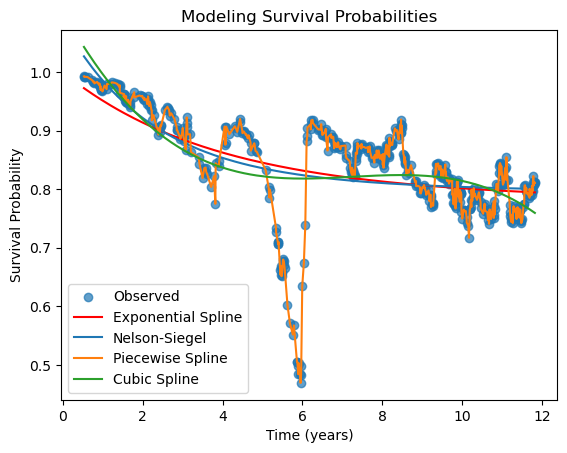

In [242]:
# Create fitted curve

plt.scatter(df['Time_to_Maturity'], df['s_tau'], label="Observed", alpha=0.7)
plt.plot(df['Time_to_Maturity'], exp_spline(df['Time_to_Maturity'], *params), label="Exponential Spline", color = 'red')
plt.plot(df['Time_to_Maturity'], df['NS_fit'], label="Nelson-Siegel")
#plt.plot(df['Time_to_Maturity'], df['cubic_fit'], label="Cubic Spline", linestyle="--")
plt.plot(df['Time_to_Maturity'], df['piecewise_fit'], label="Piecewise Spline")
plt.plot(df_sorted['Time_to_Maturity'], df_sorted['cubic_fit'], label="Cubic Spline")
plt.title('Modeling Survival Probabilities')
plt.xlabel("Time (years)")
plt.ylabel("Survival Probability")
plt.legend()
plt.show()


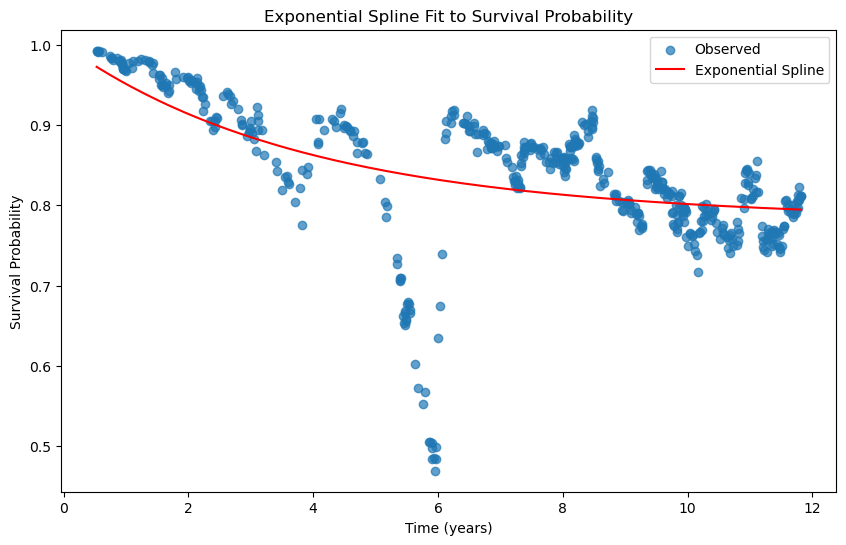

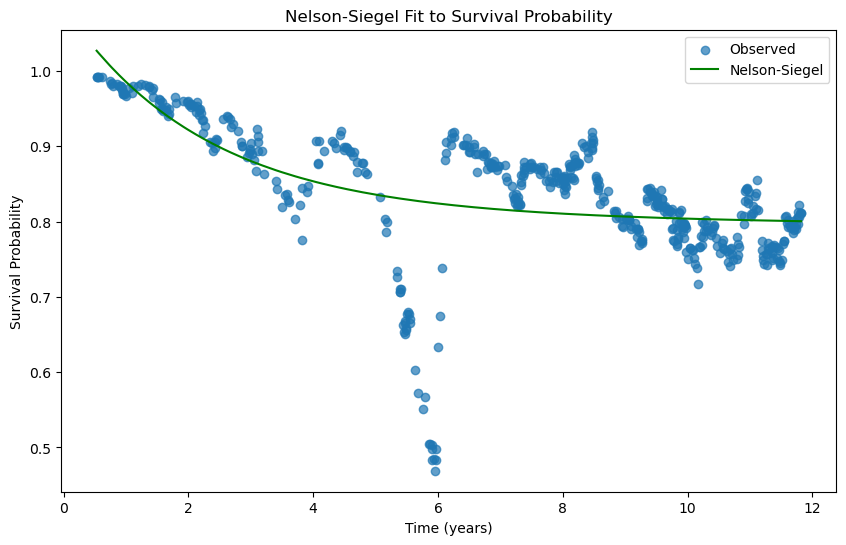

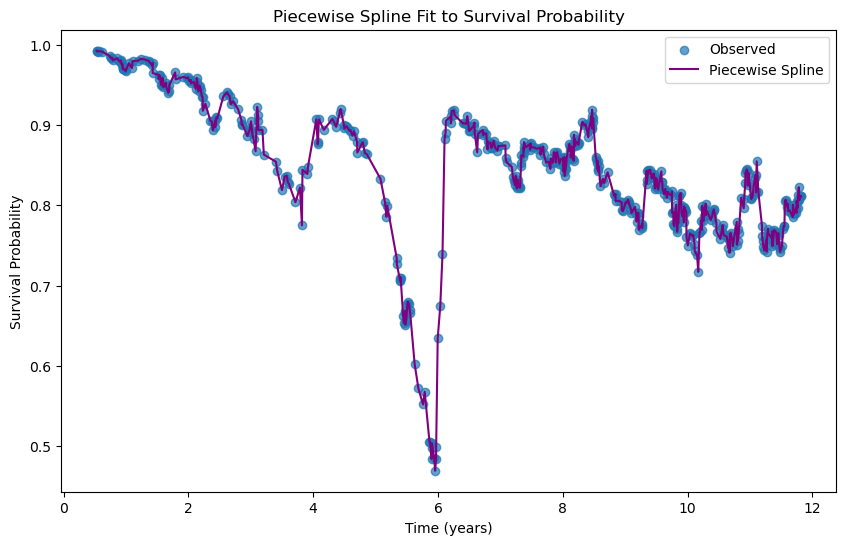

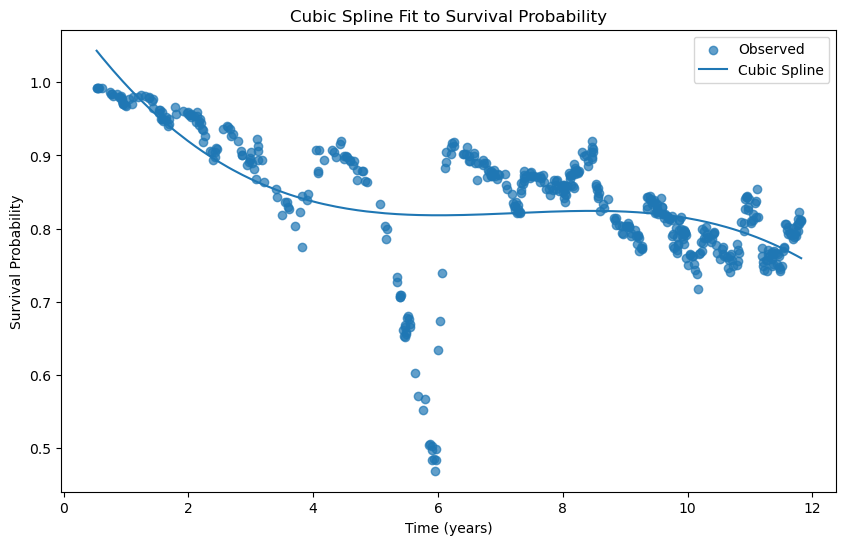

In [243]:
#Exp Spline plot
plt.figure(figsize=(10, 6))
plt.scatter(df['Time_to_Maturity'], df['s_tau'], label="Observed", alpha=0.7)
plt.plot(df['Time_to_Maturity'], exp_spline(df['Time_to_Maturity'], *params), label="Exponential Spline", color = 'red')
plt.xlabel("Time (years)")
plt.ylabel("Survival Probability")
plt.title("Exponential Spline Fit to Survival Probability")
plt.legend()
plt.show()

#Nelson-Siegel plot
plt.figure(figsize=(10, 6))
plt.scatter(df['Time_to_Maturity'], df['s_tau'], label="Observed", alpha=0.7)
plt.plot(df['Time_to_Maturity'], nelson_siegel(df['Time_to_Maturity'], *params_ns), label="Nelson-Siegel", color = 'green')
plt.xlabel("Time (years)")
plt.ylabel("Survival Probability")
plt.title("Nelson-Siegel Fit to Survival Probability")
plt.legend()
plt.show()

#Piecewise plot
plt.figure(figsize=(10, 6))
plt.scatter(df['Time_to_Maturity'], df['s_tau'], label="Observed", alpha=0.7)
plt.plot(df['Time_to_Maturity'], df['piecewise_fit'], label="Piecewise Spline", color = 'purple')
plt.xlabel("Time (years)")
plt.ylabel("Survival Probability")
plt.title("Piecewise Spline Fit to Survival Probability")
plt.legend()
plt.show()

#Cublic Spline plot
plt.figure(figsize=(10, 6))
plt.scatter(df['Time_to_Maturity'], df['s_tau'], label="Observed", alpha=0.7)
plt.plot(df_sorted['Time_to_Maturity'], df_sorted['cubic_fit'], label="Cubic Spline")
plt.xlabel("Time (years)")
plt.ylabel("Survival Probability")
plt.title("Cubic Spline Fit to Survival Probability")
plt.legend()
plt.show()

In [244]:
df_survival = df.loc[:, ['date', 's_tau', 'Q_fit_spline']]
df_survival['date'] = pd.to_datetime(df_survival['date'])
df_survival = df_survival.resample('ME', on='date').mean()
df_survival.reset_index(inplace=True)

In [245]:
#Bond information
from datetime import datetime
##Function
def generate_bond_schedule(par, coupon_rate, coupon_freq, first_coupon_date, maturity_date):
    """
    Generate bond cashflow schedule with coupon payments and principal.
    
    Parameters:
    -----------
    par : float
        Par value of the bond
    coupon_rate : float
        Annual coupon rate (e.g., 0.04 for 4%)
    coupon_freq : int
        Coupon frequency per year (e.g., 2 for semi-annual)
    first_coupon_date : datetime
        Date of first coupon payment
    maturity_date : datetime
        Bond maturity date
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with columns: date, cashflow, coupon, principal
    """
    coupon_amount = par * (coupon_rate / coupon_freq)
    
    # Generate payment dates
    freq_map = {1: '12MS', 2: '6MS', 4: '3MS', 12: 'MS'}
    freq_str = freq_map.get(coupon_freq, '6MS')
    
    dates = pd.date_range(start=first_coupon_date, end=maturity_date, freq=freq_str).tolist()
    if dates[-1] < maturity_date:
        dates.append(maturity_date)
    
    schedule = []
    for d in dates:
        cashflow = coupon_amount
        principal = 0
        if d == maturity_date:
            cashflow += par
            principal = par
        schedule.append({
            "date": d,
            "cashflow": cashflow,
            "coupon": coupon_amount,
            "principal": principal
        })
    
    return pd.DataFrame(schedule)


#Usage
coupon_freq = 2 # semi-annual
coupon_rate = 0.04
issue_date = datetime(2014, 7, 28)
first_coupon_date = datetime(2015, 4, 1)
par = 100
maturity = datetime(2026, 11, 4)

df_schedule = generate_bond_schedule(par, coupon_rate, coupon_freq, first_coupon_date, maturity)

In [246]:
from scipy.interpolate import interp1d
##Function
def create_survival_curve(df, time_col='Time_to_Maturity', q_col='Q_fit_spline'):
    """
    Create interpolated survival probability curve from fitted data.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing survival data
    time_col : str
        Column name for time to maturity
    q_col : str
        Column name for survival probabilities
    
    Returns:
    --------
    callable
        Interpolation function Q(t)
    """
    df_Q = (
        df[[time_col, q_col]]
        .dropna()
        .sort_values(time_col)
        .drop_duplicates(time_col)
    )
    
    # Enforce monotone decreasing survival
    df_Q[q_col] = df_Q[q_col].cummin()
    
    Q_curve = interp1d(
        df_Q[time_col],
        df_Q[q_col],
        kind='linear',
        fill_value='extrapolate'
    )
    
    return Q_curve


Q_curve = create_survival_curve(df)

In [247]:
# Tenors (in years) and yields (in decimals)
###############################################
##Function
def fit_yield_curve(tenors, rates, p0=None):
    """
    Fit Nelson-Siegel model to Treasury yield curve.
    
    Parameters:
    -----------
    tenors : array-like
        Tenor values in years
    rates : array-like
        Yield rates (decimal form)
    p0 : list, optional
        Initial parameter guesses [beta0, beta1, beta2, lambda]
    
    Returns:
    --------
    array
        Fitted Nelson-Siegel parameters
    """
    if p0 is None:
        p0 = [0.01, -0.01, 0.005, 1.0]
    
    params, _ = curve_fit(
        nelson_siegel,
        tenors,
        rates,
        p0=p0
    )
    
    return params


def calculate_discount_factors(time_values, yield_curve_params):
    """
    Calculate discount factors from Nelson-Siegel yield curve.
    
    Parameters:
    -----------
    time_values : array-like
        Time points in years
    yield_curve_params : array-like
        Nelson-Siegel parameters [beta0, beta1, beta2, lambda]
    
    Returns:
    --------
    array
        Discount factors Z(t) = exp(-r(t) * t)
    """
    rates = nelson_siegel(time_values, *yield_curve_params)
    discount_factors = np.exp(-rates * time_values)
    return discount_factors


# Pull yields from FRED
tenors = np.array([0.25, 0.5, 1, 2, 3, 5, 7, 10])
#rates = np.array([0.03, 0.12, 0.27, 0.56, 0.87, 1.35, 1.67, 1.90])/100 #2015-04-01
#rates = np.array([0.09, 0.05, 0.17, 0.20, 0.24, 0.37, 0.51, 0.62])/100 #2020-04-29
#rates = np.array([0.223, 0.214, 0.198, 0.187, 0.182, 0.184, 0.193, 0.204])/100 #2019-07-05
rates = np.array([0.547, 0.543, 0.517, 0.487, 0.465, 0.452, 0.451, 0.450])/100 #2024-05-10

print("Tenors (years):", tenors)
print(f'Interest Rates: {rates}')

# Fit yield curve
params_ns_rates = fit_yield_curve(tenors, rates)

# Apply to schedule
pricing_date = datetime(2024, 5, 10) #Pricing Observation Date

df_schedule_with_rates = df_schedule.copy()
df_schedule_with_rates['date'] = pd.to_datetime(df_schedule_with_rates['date'])

df_schedule_with_rates['t'] = (
    df_schedule_with_rates['date'] - pricing_date
).dt.days / 365.0

df_schedule_with_rates = df_schedule_with_rates[df_schedule_with_rates['t'] > 0]

df_schedule_with_rates['Q_fit_spline'] = Q_curve(df_schedule_with_rates['t'])
df_schedule_with_rates['risk_free_rate'] = nelson_siegel(df_schedule_with_rates['t'], *params_ns_rates)
df_schedule_with_rates['discount_factor'] = calculate_discount_factors(df_schedule_with_rates['t'], params_ns_rates)

Tenors (years): [ 0.25  0.5   1.    2.    3.    5.    7.   10.  ]
Interest Rates: [0.00547 0.00543 0.00517 0.00487 0.00465 0.00452 0.00451 0.0045 ]


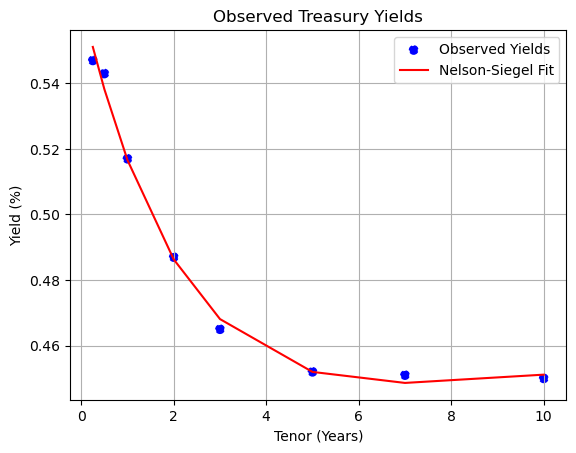

Nelson Siegel Rate Estimations: [0.55111912 0.53821174 0.51656761 0.48628884 0.46809015 0.4519715
 0.44861328 0.45113776]


In [248]:
plt.scatter(tenors, rates*100, label='Observed Yields', linestyle='--', color='blue')
plt.plot(tenors, nelson_siegel(tenors, *params_ns_rates)*100, label='Nelson-Siegel Fit', color='red')
plt.xlabel('Tenor (Years)')
plt.ylabel('Yield (%)')
plt.title('Observed Treasury Yields')
plt.legend()
plt.grid()
plt.show()
print(f"Nelson Siegel Rate Estimations: {nelson_siegel(tenors, *params_ns_rates)*100}")

In [249]:
df_schedule_with_rates['Q_fit_spline'] = df_schedule_with_rates['Q_fit_spline'].replace(0, np.nan).interpolate(method='linear') #only replaces Nan Values not 0s

In [250]:
def price_bond_with_default_risk(df_schedule, discount_factors, survival_probs, recovery_rate, par):
    """
    Price a bond incorporating default risk and recovery.
    
    Parameters:
    -----------
    df_schedule : pd.DataFrame
        Bond payment schedule with 'cashflow' column
    discount_factors : array-like
        Risk-free discount factors Z(t)
    survival_probs : array-like
        Survival probabilities Q(t)
    recovery_rate : float
        Recovery rate on default (e.g., 0.40)
    par : float
        Par value of the bond
    
    Returns:
    --------
    pd.DataFrame
        Schedule with PV calculations
    float
        Total bond present value
    """
    df = df_schedule.copy()
    df['discount_factor'] = discount_factors
    df['Q_fit_spline'] = survival_probs
    df['PV'] = 0.0
    
    # Add Q_previous column (Q(0,t_{i-1}))
    df['Q_previous'] = df['Q_fit_spline'].shift(1).fillna(1.0)
    
    for i in range(len(df)):
        z = df['discount_factor'].iloc[i]
        cash = df['cashflow'].iloc[i]
        Q_current = df['Q_fit_spline'].iloc[i]
        Q_previous = df['Q_previous'].iloc[i]
        
        # PV of cashflow if no default
        pv_cash = z * cash * Q_current
        
        # PV of recovery if default occurs in this period
        pv_recovery = z * recovery_rate * par * (Q_previous - Q_current)
        
        df['PV'].iloc[i] = pv_cash + pv_recovery
    
    total_pv = df['PV'].sum()
    
    return df, total_pv


# Price the bond
Recovery = 0.40
df_schedule_with_rates, bond_pv = price_bond_with_default_risk(
    df_schedule_with_rates,
    df_schedule_with_rates['discount_factor'].values,
    df_schedule_with_rates['Q_fit_spline'].values,
    Recovery,
    par
)

print(f'Bond PV: {bond_pv:.2f}')

Bond PV: 103.94


/var/folders/yk/03kntj1x0gxg37_rhl87gj800000gn/T/ipykernel_1854/1065449575.py:45: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['PV'].iloc[i] = pv_cash + pv_recovery
/var/folders/yk/03kntj1x0gxg37_rhl87gj800000gn/T/ipykernel_1854/10654495

In [251]:
"""
Next Steps: 
2. Add a dynamic FRED rate grabber via API keys so we can auto adjust dates
3. Get more bond and CDS data to see how we fit the whole term structure
4. Design and application for this?
 - Using streamlit or similar to make a bond pricing app?



"""

'\nNext Steps: \n2. Add a dynamic FRED rate grabber via API keys so we can auto adjust dates\n3. Get more bond and CDS data to see how we fit the whole term structure\n4. Design and application for this?\n - Using streamlit or similar to make a bond pricing app?\n\n\n\n'

In [252]:

def price_with_spread(df_schedule, spread, recovery_rate, par):
    """
    Price the bond under a constant OAS 'spread' (decimal).
    Uses existing columns: t, discount_factor, cashflow, Q_fit_spline, Q_previous.
    """
    t = df_schedule['t'].values
    Z0 = df_schedule['discount_factor'].values
    C = df_schedule['cashflow'].values
    Q = df_schedule['Q_fit_spline'].values
    Q_prev = df_schedule['Q_previous'].values

    Z_adj = Z0 * np.exp(-spread * t)

    pv_cash = Z_adj * C * Q
    pv_rec = Z_adj * recovery_rate * par * (Q_prev - Q)

    return (pv_cash + pv_rec).sum()

In [ ]:
#Option Adjusted Spread Calibration
from scipy.optimize import brentq

def calibrate_oas(df_schedule, market_price, recovery_rate, par, search_range=(-0.20, 0.20)):
    df_cf = df_schedule.copy()

    def objective(s):
        return price_with_spread(df_cf, s, recovery_rate, par) - market_price
    
    oas_decimal = brentq(objective, search_range[0], search_range[1])
    
    return {
        'oas_decimal': oas_decimal,
        'oas_bps': oas_decimal * 1e4
    }



# Calibrate OAS to market price
#P_mkt = 116.248 #At Observation Date 2015-04-07
#P_mkt = 76.2 
#P_mkt = 103.89
P_mkt = 126.83 #2024-05-10

Recovery = 0.40
par = 100.0

oas_result = calibrate_oas(df_schedule_with_rates, P_mkt, Recovery, par)

print(f"OASF (decimal): {oas_result['oas_decimal']:.6f}")
print(f"OASF: {oas_result['oas_bps']:.2f} bps")


OASF (decimal): -0.084651
OASF: -846.51 bps


{'oas_decimal': -0.08465058106782243, 'oas_bps': -846.5058106782243}

**Portfolio Construction**

In [254]:
"""
What we need:
Need more bonds from the same issuer (UAL). 
In the portfolio we chose to hedge against risk factors
Examples of risk factors:
- Interest Rate Risk
- Hazard Rate Risk (Selected as hedging risk)
- Value on Default (1-Pi/Rp)


Once we have a bunch of UAL bonds then we can measure each of them individually and determine the 
weight that bond will hold in the portfolio based on the Duration risk, Duration Hazard,
and the Value on Default Risk.


Then we build the sensitivity risk matrix based on the factor that we want to Hedge

We need to price everything with a bump to get the proper durations, not too hard to implement
"""

'\nWhat we need:\nNeed more bonds from the same issuer (UAL). \nIn the portfolio we chose to hedge against risk factors\nExamples of risk factors:\n- Interest Rate Risk\n- Hazard Rate Risk (Selected as hedging risk)\n- Value on Default (1-Pi/Rp)\n\n\nOnce we have a bunch of UAL bonds then we can measure each of them individually and determine the \nweight that bond will hold in the portfolio based on the Duration risk, Duration Hazard,\nand the Value on Default Risk.\n\n\nThen we build the sensitivity risk matrix based on the factor that we want to Hedge\n\nWe need to price everything with a bump to get the proper durations, not too hard to implement\n'

In [255]:
print(df.columns)
df_schedule_with_rates

Index(['date', 'Time_to_Maturity', 'last_value', 'spread_bps', 'spread_dec',
       'hazard', 's_tau', 'Q_fit_spline', 'NS_fit', 'piecewise_fit'],
      dtype='object')


,date,cashflow,coupon,principal,t,Q_fit_spline,risk_free_rate,discount_factor,PV,Q_previous
19,2024-10-01,2.0,2.0,0,0.394521,0.979144,0.005435,0.997858,2.786549,1.000000
20,2025-04-01,2.0,2.0,0,0.893151,0.955939,0.005208,0.995360,2.826904,0.979144
21,2025-10-01,2.0,2.0,0,1.394521,0.935364,0.005028,0.993013,2.674897,0.955939
22,2026-04-01,2.0,2.0,0,1.893151,0.917410,0.004889,0.990788,2.529449,0.935364
23,2026-10-01,2.0,2.0,0,2.394521,0.901540,0.004780,0.988621,2.410169,0.917410
24,2026-11-04,102.0,2.0,100,2.487671,0.898820,0.004762,0.988223,90.707434,0.901540


In [256]:
#Calculate Durations (Hazard and Interest Rate)

#Interest Rate Duration

def duration_oas(df_schedule, oas_decimal, recovery_rate, par, bump_bp=1.0):
    """
    OAS / interest-rate duration via bump-and-reprice.
    oas_decimal: calibrated OAS (decimal)
    bump_bp: bump in basis points (default 1 bp)
    """
    bump = bump_bp / 1e4  # 1 bp = 0.0001

    P0  = price_with_spread(df_schedule, oas_decimal,       recovery_rate, par)
    P_up = price_with_spread(df_schedule, oas_decimal + bump, recovery_rate, par)
    P_dn = price_with_spread(df_schedule, oas_decimal - bump, recovery_rate, par)

    # survival-based interest duration: - dP / (P dOAS)
    D_r = -(P_up - P_dn) / (2 * P0 * bump)
    return D_r, P0

#Hazard Rate Duration
def price_with_spread_and_hazard_bump(df_schedule, spread, recovery_rate, par, hazard_bump):
    """
    Price the bond with:
      - constant OAS 'spread' (decimal)
      - parallel hazard bump 'hazard_bump' (decimal per year)
    """
    t = df_schedule['t'].values
    Z0 = df_schedule['discount_factor'].values
    C = df_schedule['cashflow'].values
    Q_base = df_schedule['Q_fit_spline'].values

    # Spread-adjusted discount factors
    Z_adj = Z0 * np.exp(-spread * t)

    # Hazard-bumped survival probabilities: Q' = Q * exp(-Δh * t)
    Q_bump = Q_base * np.exp(-hazard_bump * t)

    # Previous survival probabilities under bumped hazard
    Q_prev_bump = np.roll(Q_bump, 1)
    Q_prev_bump[0] = 1.0

    pv_cash = Z_adj * C * Q_bump
    pv_rec  = Z_adj * recovery_rate * par * (Q_prev_bump - Q_bump)

    return (pv_cash + pv_rec).sum()


def duration_hazard(df_schedule, oas_decimal, recovery_rate, par, bump_bp=1.0):
    """
    Hazard-rate duration via parallel hazard bump.
    bump_bp: hazard bump in basis points (per year).
    """
    bump = bump_bp / 1e4  # 1 bp of hazard

    # Base price (no hazard bump)
    P0  = price_with_spread_and_hazard_bump(df_schedule, oas_decimal, recovery_rate, par, hazard_bump=0.0)
    P_up = price_with_spread_and_hazard_bump(df_schedule, oas_decimal, recovery_rate, par, hazard_bump=bump)
    P_dn = price_with_spread_and_hazard_bump(df_schedule, oas_decimal, recovery_rate, par, hazard_bump=-bump)

    D_h = -(P_up - P_dn) / (2 * P0 * bump)
    return D_h, P0


In [257]:
#Calculate VOD
par = 100
def value_on_default(price_per_100, recovery_rate, par=100.0):
    """
    VOD = 1 - Recovery / Price_fraction
    """
    price_fraction = price_per_100 / par  # e.g. 80 / 100 = 0.80
    vod = 1.0 - recovery_rate / price_fraction
    return vod


In [ ]:
#Build Sensitivity Matrix
oasf = oas_result['oas_decimal']

D_rate_i, P0_rate = duration_oas(
    df_schedule_with_rates,
    oasf,
    Recovery,
    par,
    bump_bp=1.0
)

D_hazard_i, P0_hazard = duration_hazard(
    df_schedule_with_rates,
    oasf,
    Recovery,
    par,
    bump_bp=1.0
)

# Sanity check: both base prices should match
assert abs(P0_rate - P0_hazard) < 1e-6
P0 = P0_rate #These need to match
print(P0, P0_rate, P0_hazard)
#3) VOD
VOD_i = value_on_default(P0, Recovery, par = par)

# 4) Market value for portfolio math
notional = 1_000_000  # or whatever
MV_i = P0 / 100.0 * notional #Portfolio Size

126.83000000000001 126.83000000000001 126.83000000000001


In [259]:
print(MV_i, D_rate_i, D_hazard_i, VOD_i)

1268300.0000000002 2.3597606652017165 1.518158182960262 0.6846172041315146


In [262]:
#Portfolio Neutrality Conditions
#Left off here.... need to find the MV of everything
w1 = 1.0 #Weight of 1 bond
#Creating the risk vector

"""
risk_i = [MVi, MVi * D_rate_i, MVi * D_hazard_i, MVi * VOD_i].T
"""

risk_vector_i = np.array([
    MV_i,
    MV_i * D_rate_i,
    MV_i * D_hazard_i,
    MV_i * VOD_i   # optional (only if using default-neutral framework)
])


"""
Goal is A*w = 0
b- neutral portfolio

b = [0, 0, 0, 0].T
A = [risk_vector_1, risk_vector_2, ..., risk_vector_n]

This we are going to need multiple bonds for. 
"""

risk_vector_i


array([1268300.        , 2992884.45167534, 1925480.0234485 ,
        868300.        ])

In [261]:
#Determine Portfolio Weights based on the risk factor we are looking to hedge